### Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


### Set Parameters

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'
NUM_CLASSES = 8

### Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 800 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


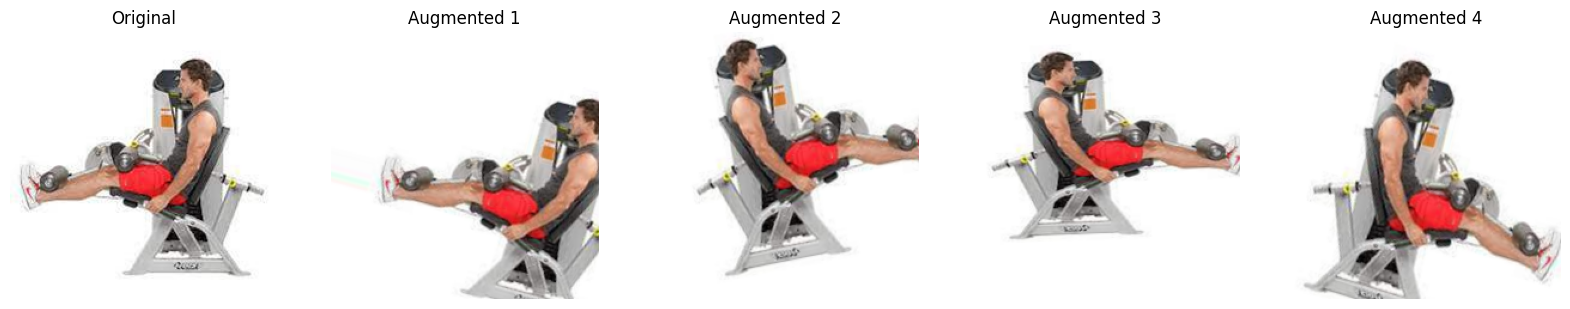

In [5]:
# Visualize augmented images
def visualize_original_and_augmented_images():

    original_images, labels = next(val_generator)
    original_image = original_images[0]

    images = [original_image]
    titles = ['Original']

    for _ in range(4):
        image_aug = train_datagen.random_transform(original_image)
        images.append(tf.keras.utils.array_to_img(image_aug))
        titles.append(f'Augmented {_+1}')

    fig, axs = plt.subplots(1, 5, figsize=(20, 7)) 
    for ax, image, title in zip(axs, images, titles):
        ax.imshow(tf.keras.utils.array_to_img(image))
        ax.set_title(title) 
        ax.axis('off')

    plt.show()

# Visualisasikan gambar
visualize_original_and_augmented_images()

### Optimization

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

# Update generator_to_dataset function
def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(BATCH_SIZE, 8), dtype=tf.float32)
        )
    )
    return dataset

In [28]:
train_dataset = generator_to_dataset(train_generator)
val_dataset = generator_to_dataset(val_generator)

In [29]:
# Apply prefetch and optimize the data pipeline
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

### Load Pre-trained MobileNetV2

In [30]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze the base model initially

### Modeling

In [31]:
# Build the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [32]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model (initially without fine-tuning)
history = model.fit(
    train_dataset, 
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/20


     18/Unknown - 5s 260ms/step - loss: 11.7847 - accuracy: 0.6892

### Fine-Tuning

In [57]:
base_model.trainable = True

# Unfreeze all layers from the last 30 layers of MobileNetV2
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),  # Reduce learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_dataset, 
    epochs=EPOCHS,
    validation_data=val_dataset 
)

Epoch 1/20
25/25 [==============================] - 12s 332ms/step - loss: 1.6463 - accuracy: 0.7688 - val_loss: 2.1252 - val_accuracy: 0.6750
Epoch 2/20
25/25 [==============================] - 8s 307ms/step - loss: 1.3002 - accuracy: 0.8763 - val_loss: 2.1173 - val_accuracy: 0.6875
Epoch 3/20
25/25 [==============================] - 7s 281ms/step - loss: 1.0624 - accuracy: 0.9137 - val_loss: 2.0324 - val_accuracy: 0.7000
Epoch 4/20
25/25 [==============================] - 7s 278ms/step - loss: 1.0713 - accuracy: 0.9075 - val_loss: 2.3049 - val_accuracy: 0.7000
Epoch 5/20
25/25 [==============================] - 7s 278ms/step - loss: 0.9919 - accuracy: 0.9350 - val_loss: 2.1790 - val_accuracy: 0.7188
Epoch 6/20
25/25 [==============================] - 7s 277ms/step - loss: 0.9478 - accuracy: 0.9287 - val_loss: 2.0596 - val_accuracy: 0.7063
Epoch 7/20
25/25 [==============================] - 7s 281ms/step - loss: 0.8754 - accuracy: 0.9438 - val_loss: 2.2459 - val_accuracy: 0.6938
Epoch

### Plot Train & Val Acc/Loss

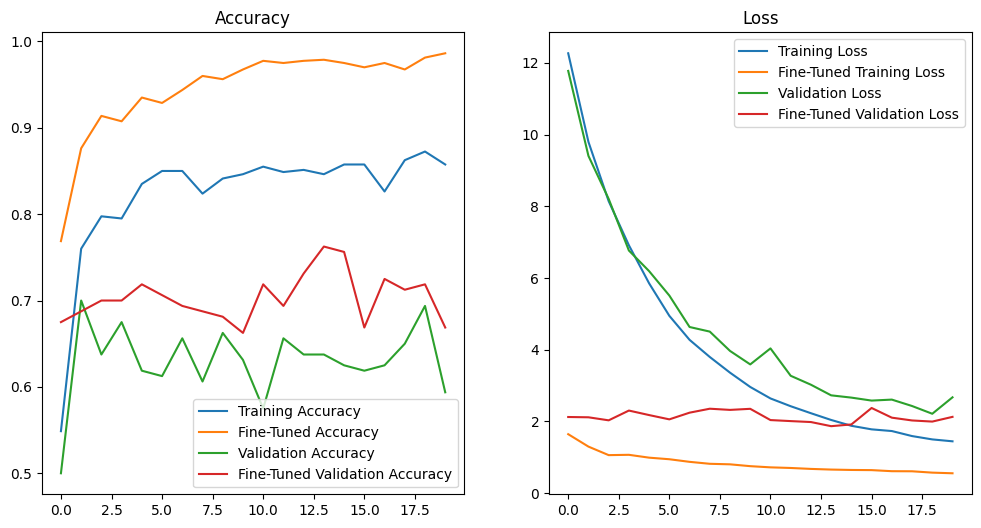

In [60]:
def plot_history(history, history_finetune):
    # Plot the accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history_finetune.history['accuracy'], label='Fine-Tuned Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot the loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history_finetune.history['loss'], label='Fine-Tuned Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history, history_finetune)
